In [873]:
# from google.colab import drive
# drive.mount('/content/drive')

In [874]:
# ! pip install pgmpy

In [875]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [876]:
import pandas as pd
import numpy as np

import common

In [877]:
data_set_path = "../temp_sets_100/"

# Patients  

## Data precess

### Read samples

In [878]:
patients_df = common.read_csv_no_rowid(data_set_path+"patients.csv")

In [879]:
admissions_date = common.read_csv_no_rowid(data_set_path+"admissions.csv").loc[:, ['subject_id', 'admittime']]
patients_mid = pd.merge(left=patients_df, right=admissions_date, how='inner', on=['subject_id'])

In [880]:
admissions_date = common.read_csv_no_rowid(data_set_path+"admissions.csv").loc[:, ['subject_id', 'admittime']]
admissions_date.drop_duplicates(subset=['subject_id'], keep='first', inplace=True)
admissions_date['admittime'] = pd.to_datetime(admissions_date['admittime'])

### Drop useless colums

In [881]:
# Drop useless colums
patients_df.drop(['expire_flag', 'dod', 'dod_hosp', 'dod_ssn'], axis=1, inplace=True)

### Deal with null values

In [882]:
# Check null value in table
common.nan_count(patients_df)

Total columns: 3
Total rows: 100
--------------
subject_id    0
gender        0
dob           0
dtype: int64


In [883]:
# Set a value replacing the null time value
nan_datetime=pd.to_datetime(0)

In [884]:
patients_df['dob'].fillna(value=nan_datetime, inplace=True)
# patients_df['dod_hosp'].fillna(value=nan_datetime, inplace=True)
# patients_df['dod_ssn'].fillna(value=nan_datetime, inplace=True)

In [885]:
common.nan_count(patients_df)

Total columns: 3
Total rows: 100
--------------
subject_id    0
gender        0
dob           0
dtype: int64


### Set the column types

In [886]:
patients_df.dtypes

subject_id     int64
gender        object
dob           object
dtype: object

In [887]:
# Transfer some date type

patients_df['dob'] = pd.to_datetime(patients_df['dob'])
# patients_df['dob'] = patients_df['dob'].astype(np.int64)
# patients_df['dod'] = pd.to_datetime(patients_df['dod'])
# patients_df['dod_hosp'] = pd.to_datetime(patients_df['dod_hosp'])
# patients_df['dod_ssn'] = pd.to_datetime(patients_df['dod_ssn'])

In [888]:
patients_df.dtypes

subject_id             int64
gender                object
dob           datetime64[ns]
dtype: object

### Process dod_hosp and dod_ssn

In [889]:
from pandas import NaT

# Define a method to deal with death time
def dod_process(df):
    '''
    Note that DOD merged together DOD_HOSP and DOD_SSN, giving priority to DOD_HOSP if both were recorded
    '''
    
    if not (pd.isna(df['dod_hosp']) or pd.isna(df['dod_ssn'])):
        return NaT
    else:
        return df['dod_ssn']

In [890]:
# patients_df['dod_ssn'] = patients_df.apply(dod_process, axis=1)

In [891]:
patients_df

,subject_id,gender,dob
0,569,M,2021-11-04
1,26282,F,2074-03-20
2,1762,F,2120-03-19
3,14481,M,1816-05-08
4,21470,M,2195-05-20
...,...,...,...
95,23647,M,2077-02-13
96,26485,F,2075-08-15
97,26884,F,2067-01-31
98,49024,M,2055-02-17


### Merge table

In [892]:
patients_df = pd.merge(left=patients_df, right=admissions_date, how='inner', on=['subject_id'])

### Process dob

1. some patients who was rather than 89 years old, whose age were set over 300 years. so I need to try to restore a reasonable random date of birth, to let their age when admitted were reasonable.
2. MIMIC-III has shifted all the date data. I try to shift the `admittime` back to be 2001 - 2012, and accross `addmittime` to reset the birth date

In [893]:
import datetime
import random

def adjust_age_over_90(df):
    '''
    This method is to adjust the invalid date in 'dob' (which is 18xx)
    Process: Use the admittime minus 90 - 100 years, to let the age of patients are between 90 to 100
    '''

    years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
    random_days_10_years = datetime.timedelta(days = random.randint(0, 10)*365)
    
    if (df['dob'] - datetime.datetime(1970,1,1)).total_seconds() < 0:
        return (df['admittime'] - years_100 + random_days_10_years)
    else:
        return df['dob']

In [894]:
def get_birth_delta(df):
    '''
    Get the difference bwteen birth and admition 
    '''
    return df['admittime'] - df['dob']

In [895]:
def adjust_admittime(df):
    return pd.Timestamp(year=random.randint(2001, 2012), month=df['admittime'].month, day=df['admittime'].day)

In [896]:
def reset_dob(df):
    dob = df['admittime'] - df['dob']
    return pd.to_datetime(dob.date())

In [897]:
patients_df['dob'] = patients_df.apply(adjust_age_over_90, axis=1)
patients_df['dob'] = patients_df.apply(get_birth_delta, axis=1)
patients_df['admittime'] = patients_df.apply(adjust_admittime, axis=1)
patients_df['dob'] = patients_df.apply(reset_dob, axis=1)
# patients_df = patients_df.drop(['admittime'], axis=1)

In [898]:
patients_df.drop(['admittime'], axis=1, inplace=True)

In [900]:
# import datetime
# import random

# def adjust_age_over_90(df):
#     '''
#     This method is to adjust the invalid date in 'dob' (which is 18xx)
#     Process: Plus 300 - 310 years from original date, to let the age of patients are between 90 to 100
#     '''

#     years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
#     random_days_10_years = datetime.timedelta(days = random.randint(0, 10*365))
    
#     # if patient was not dead, give a random reasonable birth
#     if pd.isna(df['dod']):
#         if np.int64(df['dob'].to_numpy()) < 0:
#             return df['dob'] + years_100 + years_100 + years_100 + random_days_10_years
#         else:
#             return df['dob']
#     # if patient was dead, use the death date - random 90 - 100 year, to make sure this patient's age was between 90 to 100
#     else:
#         return df['dod'] - years_100 + random_days_10_years

In [901]:
# from pandas import NaT

# patients_df['dod_hosp'] = patients_df['dod_hosp'].apply(lambda x: 1 if not pd.isna(x) else 0)
# patients_df['dod_ssn'] = patients_df['dod_ssn'].apply(lambda x: 1 if not pd.isna(x) else 0)
# patients_df['dod_live'] = patients_df['dod_live'].apply(lambda x: 1 if not pd.isna(x) else 0)

---

##  Build Model

In [902]:
from sdv.lite import TabularPreset
from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN 
from sdv.tabular import TVAE
from sdv.constraints import FixedCombinations

In [903]:
patients_df.columns

Index(['subject_id', 'gender', 'dob'], dtype='object')

### Set constraints

#### Build custom constrains

In [904]:
from sdv.constraints import create_custom_constraint

In [905]:
# DOD
def dod_data_unique_is_valid(column_names, data):
    one = (pd.isna(data['dod']) == False) & (pd.isna(data['dod_hosp']) == False) & (pd.isna(data['dod_ssn']) == True) #& (data['dod'] == data['dod_hosp'])
    two = (pd.isna(data['dod']) == False) & (pd.isna(data['dod_hosp']) == True) & (pd.isna(data['dod_ssn']) == False) #& (data['dod'] == data['dod_ssn'])
    three = (pd.isna(data['dod']) == True) & (pd.isna(data['dod_hosp']) == True) & (pd.isna(data['dod_ssn']) == True)
    is_only = one | two | three
    return is_only

def dod_data_unique_trasform(column_names, data):
    # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
    return data

def dod_data_unique_reverse_transform(column_names, transformed_data):
    # print(transformed_data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])

    one = (pd.isna(transformed_data['dod']) == False) & (pd.isna(transformed_data['dod_hosp']) == False) & (pd.isna(transformed_data['dod_ssn']) == True)
    two = (pd.isna(transformed_data['dod']) == False) & (pd.isna(transformed_data['dod_hosp']) == True) & (pd.isna(transformed_data['dod_ssn']) == False)

    transformed_data['dod_hosp'] = transformed_data[one]['dod']
    transformed_data['dod_ssn'] = transformed_data[two]['dod']

    return transformed_data


DodUniqueProcess = create_custom_constraint(
    is_valid_fn=dod_data_unique_is_valid,
    transform_fn=dod_data_unique_trasform,
    reverse_transform_fn=dod_data_unique_reverse_transform
)

dod_data_unique_constraint = DodUniqueProcess(
    column_names=['dod_hosp', 'dod_ssn']
)

In [906]:
# # DOB
# def dob_nut_null(column_names, data):
#     return pd.isna(data['dob']) == False

# DobNotNull = create_custom_constraint(
#     is_valid_fn=dob_nut_null
# )

# dob_not_null_constraint = DobNotNull(
#     column_names=['dob']
# )

#### Predefined Constraints

In [907]:
from sdv.constraints import Unique

unique_subject_id_constraint = Unique(
    column_names=['subject_id']
)

In [908]:
# from sdv.constraints import ScalarInequality

# dob_before_2200 = ScalarInequality(
#     column_name='dob',
#     relation='<=',
#     value="2200-01-01"
# )

# dob_after_2000 = ScalarInequality(
#     column_name='dob',
#     relation='>=',
#     value="2000-01-01"
# )

In [909]:
# from sdv.constraints import Inequality

# dob_before_dod = Inequality(
#     low_column_name='dob',
#     high_column_name='dod'
# )

### Build and train model

In [910]:
constrains = [unique_subject_id_constraint]

In [911]:
# model = CopulaGAN(
#     constraints=constrains, 
#     cuda=True)

In [912]:
# model = TabularPreset(name='FAST_ML')
model = GaussianCopula(
    constraints=constrains
)

In [913]:
len(patients_df)

100

In [914]:
train_data = patients_df
model.fit(train_data)

### Save model

In [915]:
import cloudpickle

with open(data_set_path + "100_models/" + "patients_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [916]:
# model.save(data_set_path + "100_models/" + "patients_model.pkl")

## Generate synthetic data

In [917]:
import cloudpickle

with open(data_set_path + "100_models/" + "patients_model.pkl", 'rb') as f:
    model = cloudpickle.load(f)

In [918]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 100/100 [00:00<00:00, 10994.24it/s]


In [919]:
sample.head(30)

,subject_id,gender,dob
0,10573,M,1939-02-20
1,62860,M,1929-05-31
2,50256,M,1919-03-04
3,8146,M,1945-08-01
4,14400,M,1919-11-28
5,49250,F,1944-05-19
6,45449,M,1930-08-22
7,9835,M,1928-07-21
8,44623,M,1929-12-09
9,10976,F,1922-05-24


---

## Evaluate data

In [920]:
from sdv.evaluation import evaluate

In [921]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

nan

In [922]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [923]:
evaluate(sample, train_data)

0.646416144086084

<AxesSubplot:>

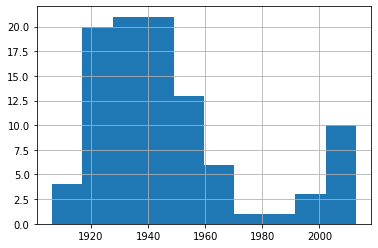

In [924]:
train_data['dob'].hist()

<AxesSubplot:>

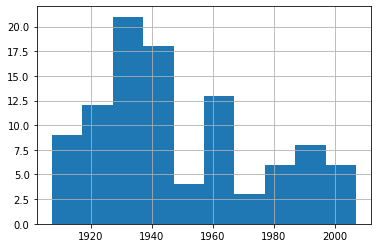

In [925]:
sample['dob'].hist()

<AxesSubplot:>

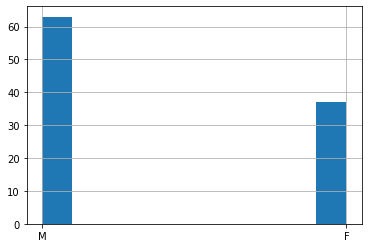

In [926]:
sample['gender'].hist()

<AxesSubplot:>

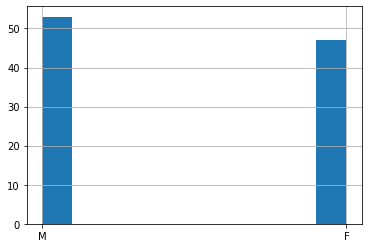

In [927]:
train_data['gender'].hist()

---

### Evaluate timeseries data (not accurate in tis table)

In [928]:
from sdv.metrics.timeseries import LSTMDetection, TSFCDetection

In [929]:
metadata_2 = model.get_metadata().to_dict()

In [930]:
metadata_2['entity_columns']=['subject_id']

In [931]:
metadata_2

{'fields': {'subject_id': {'type': 'numerical',
   'subtype': 'integer',
   'transformer': 'integer'},
  'gender': {'type': 'categorical', 'transformer': 'categorical_fuzzy'},
  'dob': {'type': 'datetime', 'transformer': 'datetime'}},
 'constraints': [{'constraint': 'sdv.constraints.tabular.Unique',
   'column_names': ['subject_id']}],
 'model_kwargs': {'GaussianCopula': {'field_distributions': {'subject_id.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'gender.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
    'dob.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian'},
   'default_distribution': copulas.univariate.truncated_gaussian.TruncatedGaussian,
   'categorical_transformer': 'categorical_fuzzy'}},
 'name': None,
 'primary_key': None,
 'sequence_index': None,
 'entity_columns': ['subject_id'],
 'context_columns': []}

In [932]:
LSTMDetection.compute(sample, train_data, metadata_2)

0.5

In [933]:
patients_df.loc[:, ['subject_id', 'dob']].to_csv(data_set_path + "date_dob.csv", index=0)